In [31]:
import sys
import os
import xarray as xr
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
import numpy as np
from isca_tools.utils.land import get_ocean_coords, get_land_coords
from isca_tools.utils import area_weighting, lat_lon_slice
from isca_tools.land import write_land
from isca_tools.sst import write_sst

## Write SST file
Take annual average of previous 5m depth experiment, take annual average so can use these fixed SSTs in new experiment.

In [32]:
# xr.load_dataset('zhang_example/sst.nc', decode_times=False)

In [33]:
# Load in SSTs from previous simulation, and take annual average to get SSTs to use
sst_file = 'tau_sweep/aquaplanet/k=1/'
use_time_start = 360*2
sst_use = isca_tools.load_dataset(sst_file)['t_surf']
sst_use = sst_use.sel(time=slice(use_time_start, np.inf))
sst_use = sst_use.mean(dim='time').load()

In [34]:
isca_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/'
exp_dir = 'rossbypalooza/vary_rot_rate/1/'
write_sst(isca_path+exp_dir+'sst', isca_path+exp_dir+'namelist.nml', sst_use.to_numpy())

ValueError: The file /Users/joshduffield/Documents/StAndrews/Isca/jobs/rossbypalooza/vary_rot_rate/1/sst.nc already exists. Delete or re-name this to continue.

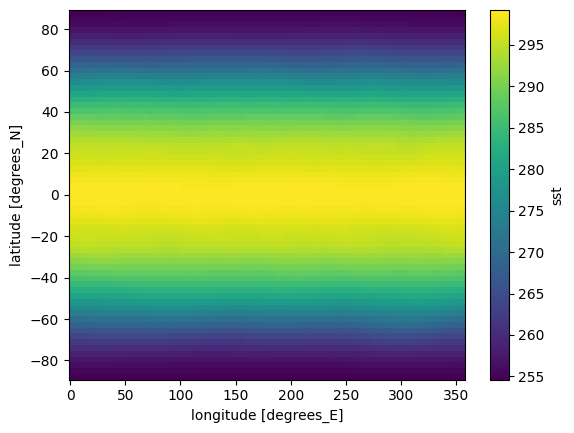

In [35]:
sst_saved = xr.load_dataset(isca_path+exp_dir+'sst.nc')
sst_saved.sst.plot()

In [36]:
sst_saved.latb

<xarray.DataArray 'latb' (latb: 65)>
array([-9.000000e+01, -8.657775e+01, -8.375703e+01, -8.095502e+01,
       -7.815835e+01, -7.536394e+01, -7.257070e+01, -6.977814e+01,
       -6.698602e+01, -6.419420e+01, -6.140258e+01, -5.861111e+01,
       -5.581976e+01, -5.302849e+01, -5.023730e+01, -4.744616e+01,
       -4.465506e+01, -4.186400e+01, -3.907297e+01, -3.628196e+01,
       -3.349098e+01, -3.070002e+01, -2.790907e+01, -2.511813e+01,
       -2.232720e+01, -1.953628e+01, -1.674537e+01, -1.395447e+01,
       -1.116357e+01, -8.372673e+00, -5.581780e+00, -2.790890e+00,
       -3.180555e-14,  2.790890e+00,  5.581780e+00,  8.372673e+00,
        1.116357e+01,  1.395447e+01,  1.674537e+01,  1.953628e+01,
        2.232720e+01,  2.511813e+01,  2.790907e+01,  3.070002e+01,
        3.349098e+01,  3.628196e+01,  3.907297e+01,  4.186400e+01,
        4.465506e+01,  4.744616e+01,  5.023730e+01,  5.302849e+01,
        5.581976e+01,  5.861111e+01,  6.140258e+01,  6.419420e+01,
        6.698602e+01,  6.977814e+01,  7.257070e+01,  7.536394e+01,
        7.815835e+01,  8.095502e+01,  8.375703e+01,  8.657775e+01,
        9.000000e+01])
Coordinates:
  * latb     (latb) float64 -90.0 -86.58 -83.76 -80.96 ... 83.76 86.58 90.0
Attributes:
    units:    degrees_N

In [37]:
sst_use

<xarray.DataArray 't_surf' (lat: 64, lon: 128)>
array([[254.71924, 254.76212, 254.76344, ..., 254.756  , 254.75754,
        254.7591 ],
       [255.19221, 255.22833, 255.23152, ..., 255.21498, 255.2179 ,
        255.22115],
       [256.03583, 256.06396, 256.06808, ..., 256.04752, 256.05087,
        256.05545],
       ...,
       [255.89781, 255.90892, 255.897  , ..., 255.95604, 255.94379,
        255.93208],
       [255.14134, 255.16774, 255.16344, ..., 255.18456, 255.18105,
        255.17728],
       [254.74548, 254.78539, 254.78468, ..., 254.78949, 254.78827,
        254.78726]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86

## Create land
Create zonal strip of land in mid latitude to keep peak temperature near this region as vary rotation rate.

In [61]:
lat_min = 20
lat_max = 60
# lat_min = 40
# lat_max = 80
write_land(isca_path+exp_dir+'land', isca_path+exp_dir+'namelist.nml', 'square', [lat_min, lat_max, 0-10, 360+10])

ValueError: The file /Users/joshduffield/Documents/StAndrews/Isca/jobs/rossbypalooza/vary_rot_rate/1/land.nc already exists. Delete or re-name this to continue.

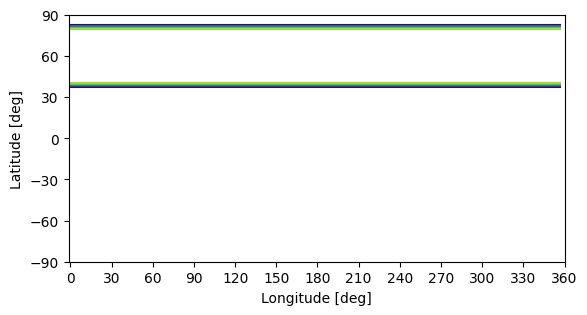

In [60]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, 'land2.nc')
isca_tools.plot.show_land(land_file_name)

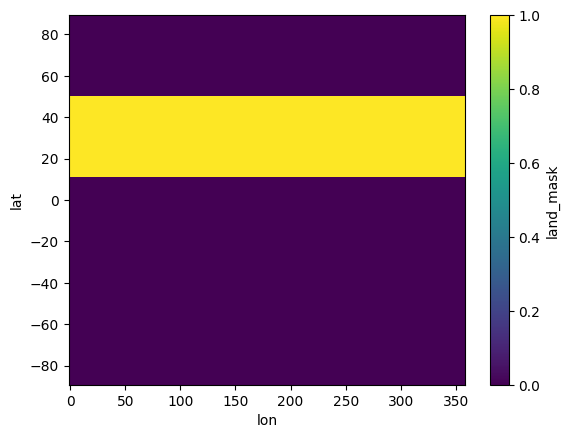

In [53]:
xr.load_dataset(land_file_name).land_mask.plot()

## Sanity check that SST does not change with time
For land, it clearly does though.

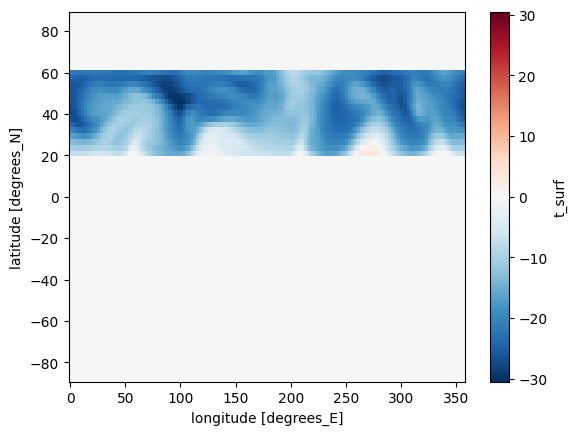

In [42]:
ds = isca_tools.load_dataset(exp_dir)['t_surf']
(ds.isel(time=-1)-ds.isel(time=0)).plot()